# 1. Basic Setup

In [1]:
# mediapipe: Able to get keypoints from the body
# scikit-learn: Tools for predictive data analysis

In [2]:
pip install tensorflow opencv-python matplotlib mediapipe scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import cv2
import os
import time
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp

# 2. Drawing Keypoints using MP

In [2]:
mp_holistic = mp.solutions.holistic # Make detections (pose, hands, face etc.)
mp_drawing = mp.solutions.drawing_utils # Draw keypoints
mp_face_mesh = mp.solutions.face_mesh # For Face connections (keypoints)

In [3]:
def mp_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    # Tells NumPy/OpenCV that I won’t modify the image during processing, 
    # which can save memory copying and speed things up
    results = model.process(image)
    image.flags.writeable = True # So I can draw on it later
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
# mp_holistic.POSE_CONNECTIONS?? # Shows the connection map, a relationship between landmarks

In [5]:
def draw_developed_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255, 212, 116), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(138, 89, 16), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255, 134, 124), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(215, 45, 67), thickness=2, circle_radius=2))

In [6]:
# Webcam setting 
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): # While accessing my webcam
        ret, frame = cap.read() # Read feed # Return value, frame (image value)
        
        image, results = mp_detection(frame, holistic)
        # print(results)

        draw_developed_landmarks(image, results)
        
        cv2.imshow('OpenCV Feed', image) # Show frame to my screen
        
        if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
        # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not. 
cap.release()
cv2.destroyAllWindows()

In [7]:
# results.face_landmarks      # returns dictionary, landmark: x, y, z values
# results.face_landmarks.landmark        # returns array, x, y, z values
# len(results.face_landmarks.landmark)   # number of total keypoints a face has
# print(len(results.left_hand_landmarks.landmark))
# If you try to access a landmark that wasn’t present on the webcam, it will throw an error

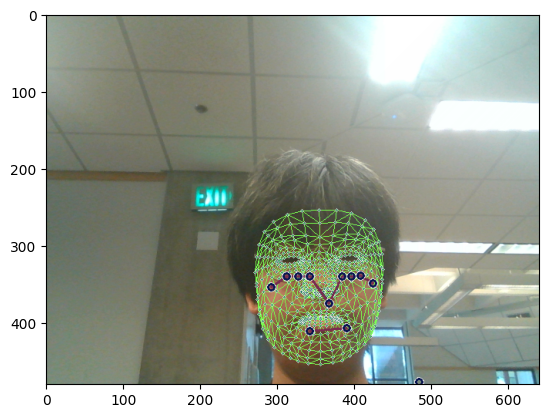

In [11]:
draw_developed_landmarks(image, results)
# draw_landmarks doesn't return the image, but applies the landmark visualizations to the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [7]:
# Into numpy
# results.pose_landmarks.landmark[0].visibility

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    # pose, len(pose) = 33*4, pose.shape = (132,)
    lefth = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    righth = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    return np.concatenate([pose, face, lefth, righth])

In [8]:
extract_keypoints(results).shape

(1662,)

# 4. Folders for Data

**Action Detection**: Uses sequence of data(frames) rather than a single frame. 

In [9]:
PATH = os.path.join('MP_Data')
actions = np.array(['Hello', 'Thanks', 'IloveYou'])

# I will use 30 frames to detect sign language
no_sequences = 30       # Thirty videos worth of data
sequence_length = 30    # Videos are going to be 30 frames in length

# 30 videos * 30 frames * 3 actions * 1662 keypoints = data size

In [10]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(PATH, action, str(sequence)))
        except:
            pass

# 5. Collecting Keypoint Values for Training and Testing

In [11]:
# Webcam setting 
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions: # While accessing my webcam
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read() # Read feed # Return value, frame (image value)
                
                image, results = mp_detection(frame, holistic)
                # print(results)
        
                draw_developed_landmarks(image, results)
    
                if frame_num == 0: # If I'm at frame 0, take a break for 2000 ms
                    # Outputting text on screen
                    # (120, 200): position, font, font_size, font_color(BGR), line width, line_type 
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),
                                (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence),
                                (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    
                keypoints = extract_keypoints(results)
                np_path = os.path.join(PATH, action, str(sequence), str(frame_num))
                np.save(np_path, keypoints)
                # np.load(<file name>)
                
                cv2.imshow('OpenCV Feed', image) # Show frame to my screen
                    
                if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
                # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not.

    cap.release()
    cv2.destroyAllWindows()

# 6. Preprocess Data, Create Features, and Labeling

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [13]:
label_map = {label:ind for ind, label in enumerate(actions)}
sequences, labels = [], [] # 1 sequence = 1 video
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            loc = np.load(os.path.join(PATH, action, str(sequence), '{}.npy'.format(str(frame_num))))
            window.append(loc)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
print(np.array(sequences).shape) # 30videos * 3actions = 90videos, 1video = 30frames, 1frame = 1662landmarks
print(np.array(labels).shape)

(90, 30, 1662)
(90,)


In [17]:
x = np.array(sequences)
y = to_categorical(labels).astype(int) # convert a class vector (integers) to binary class metrix 
# 0 = [1 0 0]
# 1 = [0 1 0]
# 2 = [0 0 1]

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05) # 85, 5

# 7. Building and Training LSTM Neural Network

In [19]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [20]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir) # Allows to monitor neural network

**Unit**: Each unit is like a "memory slot" that learns a pattern across time. Bigger units → more capacity to learn complex patterns, but also more parameters → heavier training, risk of overfitting.

In [21]:
model_1 = Sequential()
# Straightforward way to build neural network models by stacking layers
model_1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model_1.add(LSTM(128, return_sequences=True, activation='relu'))
model_1.add(LSTM(64, return_sequences=False, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(actions.shape[0], activation='softmax'))
# Softmax function: Normalize the output of a network to a probability distribution over predicted output classes
# Ex. [0.7, 0.2, 0.1] --> np.argmax = 0.7, which means the video it's predicting is likely to be 'Hello'

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# Categorical_crossentropy is a loss function particularly for a multiclass classification model
# Metricx is an optional, but it shows how often predictions match one-hot labels, good for analyzation

C:\venvs\venvs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model_1.fit(x_train, y_train, epochs=1000, callbacks=[tb_callback])
# The number of epochs might be too high for such a small dataset
# can stop training early if the accuracy is acceptable and the loss has stopped consistently decreasing

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - categorical_accuracy: 0.3059 - loss: 2.3702
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.2706 - loss: 3.8972
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - categorical_accuracy: 0.3294 - loss: 2.6312
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.2941 - loss: 2.4930
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_accuracy: 0.4118 - loss: 1.1752
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.3882 - loss: 1.0743
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_accuracy: 0.4118 - loss: 1.0424
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.5647 - loss: 1.0196
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - categorical_accuracy: 0.5176 - loss: 0.9358
Epoch 10/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.4000 - loss: 1.0800
Epoch 11/1000
3/3 ━━━━━━━━━━━

In [39]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 596,677 (2.28 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

On cmd: \
**tensorboard --logdir=.**  \
This command opens TensorBoard in the current folder (e.g., ~/logs/train) \
Copy and paste the link provided to access TensorBoard in your browser (e.g., http://localhost:6006/)

# 8. Predictions

In [40]:
res = model_1.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


In [41]:
print(res) # Shows that it's likely to be 'Hello
print(y_test)
print('Probability: {}'.format(np.sum(res[4])))
print('Prediction: {}'.format(actions[np.argmax(res[4])]))
print('Real_Value: {}'.format(actions[np.argmax(y_test[4])]))

# 4/5 were correct

[[7.6628909e-02 2.1012564e-05 9.2335010e-01]
 [1.5367034e-01 1.6037151e-05 8.4631360e-01]
 [8.1388773e-03 7.1052814e-06 9.9185395e-01]
 [2.0127856e-14 9.9984646e-01 1.5356166e-04]
 [1.6597573e-02 1.0454718e-05 9.8339200e-01]]
[[1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]]
Probability: 1.0
Prediction: IloveYou
Real_Value: IloveYou


# 9. Saving Model/Weights

In [28]:
model_1.save(os.path.join('Models', 'SignRecognition.h5'))

In [40]:
# del model_1

In [42]:
model_1 = load_model(os.path.join('Models', 'SignRecognition.h5'))
# model_1 = load_weights('SignRecognition.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [43]:
yhat = model_1.predict(x_test)
print(yhat)
yhat = np.argmax(yhat, axis=1).tolist()
print(yhat)
yTrue = np.argmax(y_test, axis=1).tolist() # converts one-hot code into integer
print(yTrue)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
[[7.6628909e-02 2.1012564e-05 9.2335010e-01]
 [1.5367034e-01 1.6037151e-05 8.4631360e-01]
 [8.1388773e-03 7.1052814e-06 9.9185395e-01]
 [2.0127856e-14 9.9984646e-01 1.5356166e-04]
 [1.6597573e-02 1.0454718e-05 9.8339200e-01]]
[2, 2, 2, 1, 2]
[0, 2, 2, 1, 2]


In [44]:
# Multilabel Confusion Matrix (MCM)
# True Negative (0, 0)
# False Negative (1, 0)
# True Positive (1, 1)
# False Positive (0, 1)
multilabel_confusion_matrix(yTrue, yhat)
# I got three 2x2 matrices --> 3 classes/labels

array([[[4, 0],
        [1, 0]],

       [[4, 0],
        [0, 1]],

       [[1, 1],
        [0, 3]]], dtype=int64)

In [45]:
accuracy_score(yTrue, yhat)

0.8

# 11. Testing

In [66]:
COLORS = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_visual(res, actions, input_frame, COLORS):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), COLORS[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

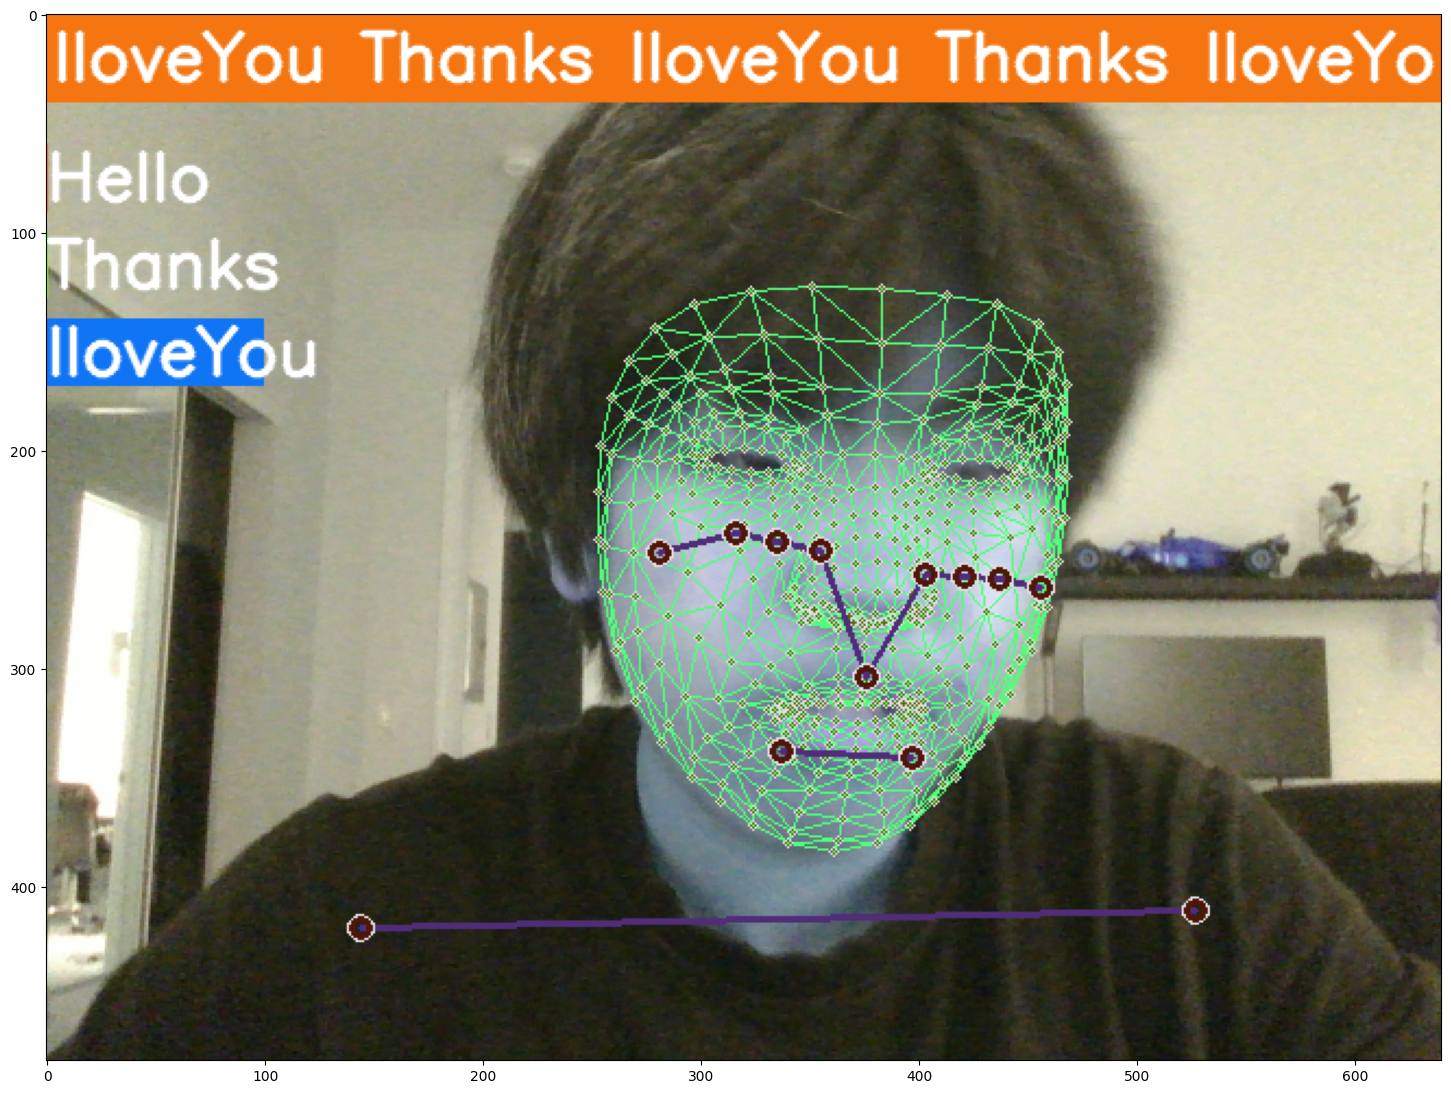

In [67]:
plt.figure(figsize=(18,18))
plt.imshow(prob_visual(res,actions,image,COLORS))

In [88]:
sequence = []
sentence = []
predictions = []
threshold = 0.4   # Threshold = Percentage, res[np.argmax(res)]
cap = cv2.VideoCapture(0) # Access a device index, 0 is the default (webcam)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): # While accessing my webcam
        ret, frame = cap.read() # Read feed # Return value, frame (image value)
        
        image, results = mp_detection(frame, holistic)
        # print(results)

        draw_developed_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints) 
        # sequence.insert(0, keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model_1.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))
            # print(actions[np.argmax(res)])

        # Visual Logic, shows which sign language was detected in order
        
        if predictions:
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if sentence[-1] != actions[np.argmax(res)]:
                            sentence.append(actions[np.argmax(res)])
                    else: sentence.append(actions[np.argmax(res)])
        if len(sentence) > 5: sentence = sentence[-5:]
        image = prob_visual(res,actions,image,COLORS)
        cv2.rectangle(image, (0,0), (640,40), (245,117,16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        cv2.imshow('OpenCV Feed', image) # Show frame to my screen
        
        if cv2.waitKey(10) & 0xFF == ord('q'): break # Break this loop if keyboard key q is pressed
        # Waits 10 ms for a key event, returns integer representing the key pressed, -1 if not. 
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━